In [21]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("yuriykatser/skoltech-anomaly-benchmark-skab")

print("Path to dataset files:", path)

Path to dataset files: /home/zepeng/.cache/kagglehub/datasets/yuriykatser/skoltech-anomaly-benchmark-skab/versions/1


In [22]:
csv_files = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".csv"):
            csv_files.append(os.path.join(root, file))

# anomaly - free
anomaly_free_files = sorted([f for f in csv_files if "anomaly-free" in f])

# anomaly
anomaly_files = sorted([f for f in csv_files if "anomaly-free" not in f])

print(f"anomaly_free: {len(anomaly_free_files)}")
print(f"with_anomaly: {len(anomaly_files)}")


anomaly_free: 1
with_anomaly: 34


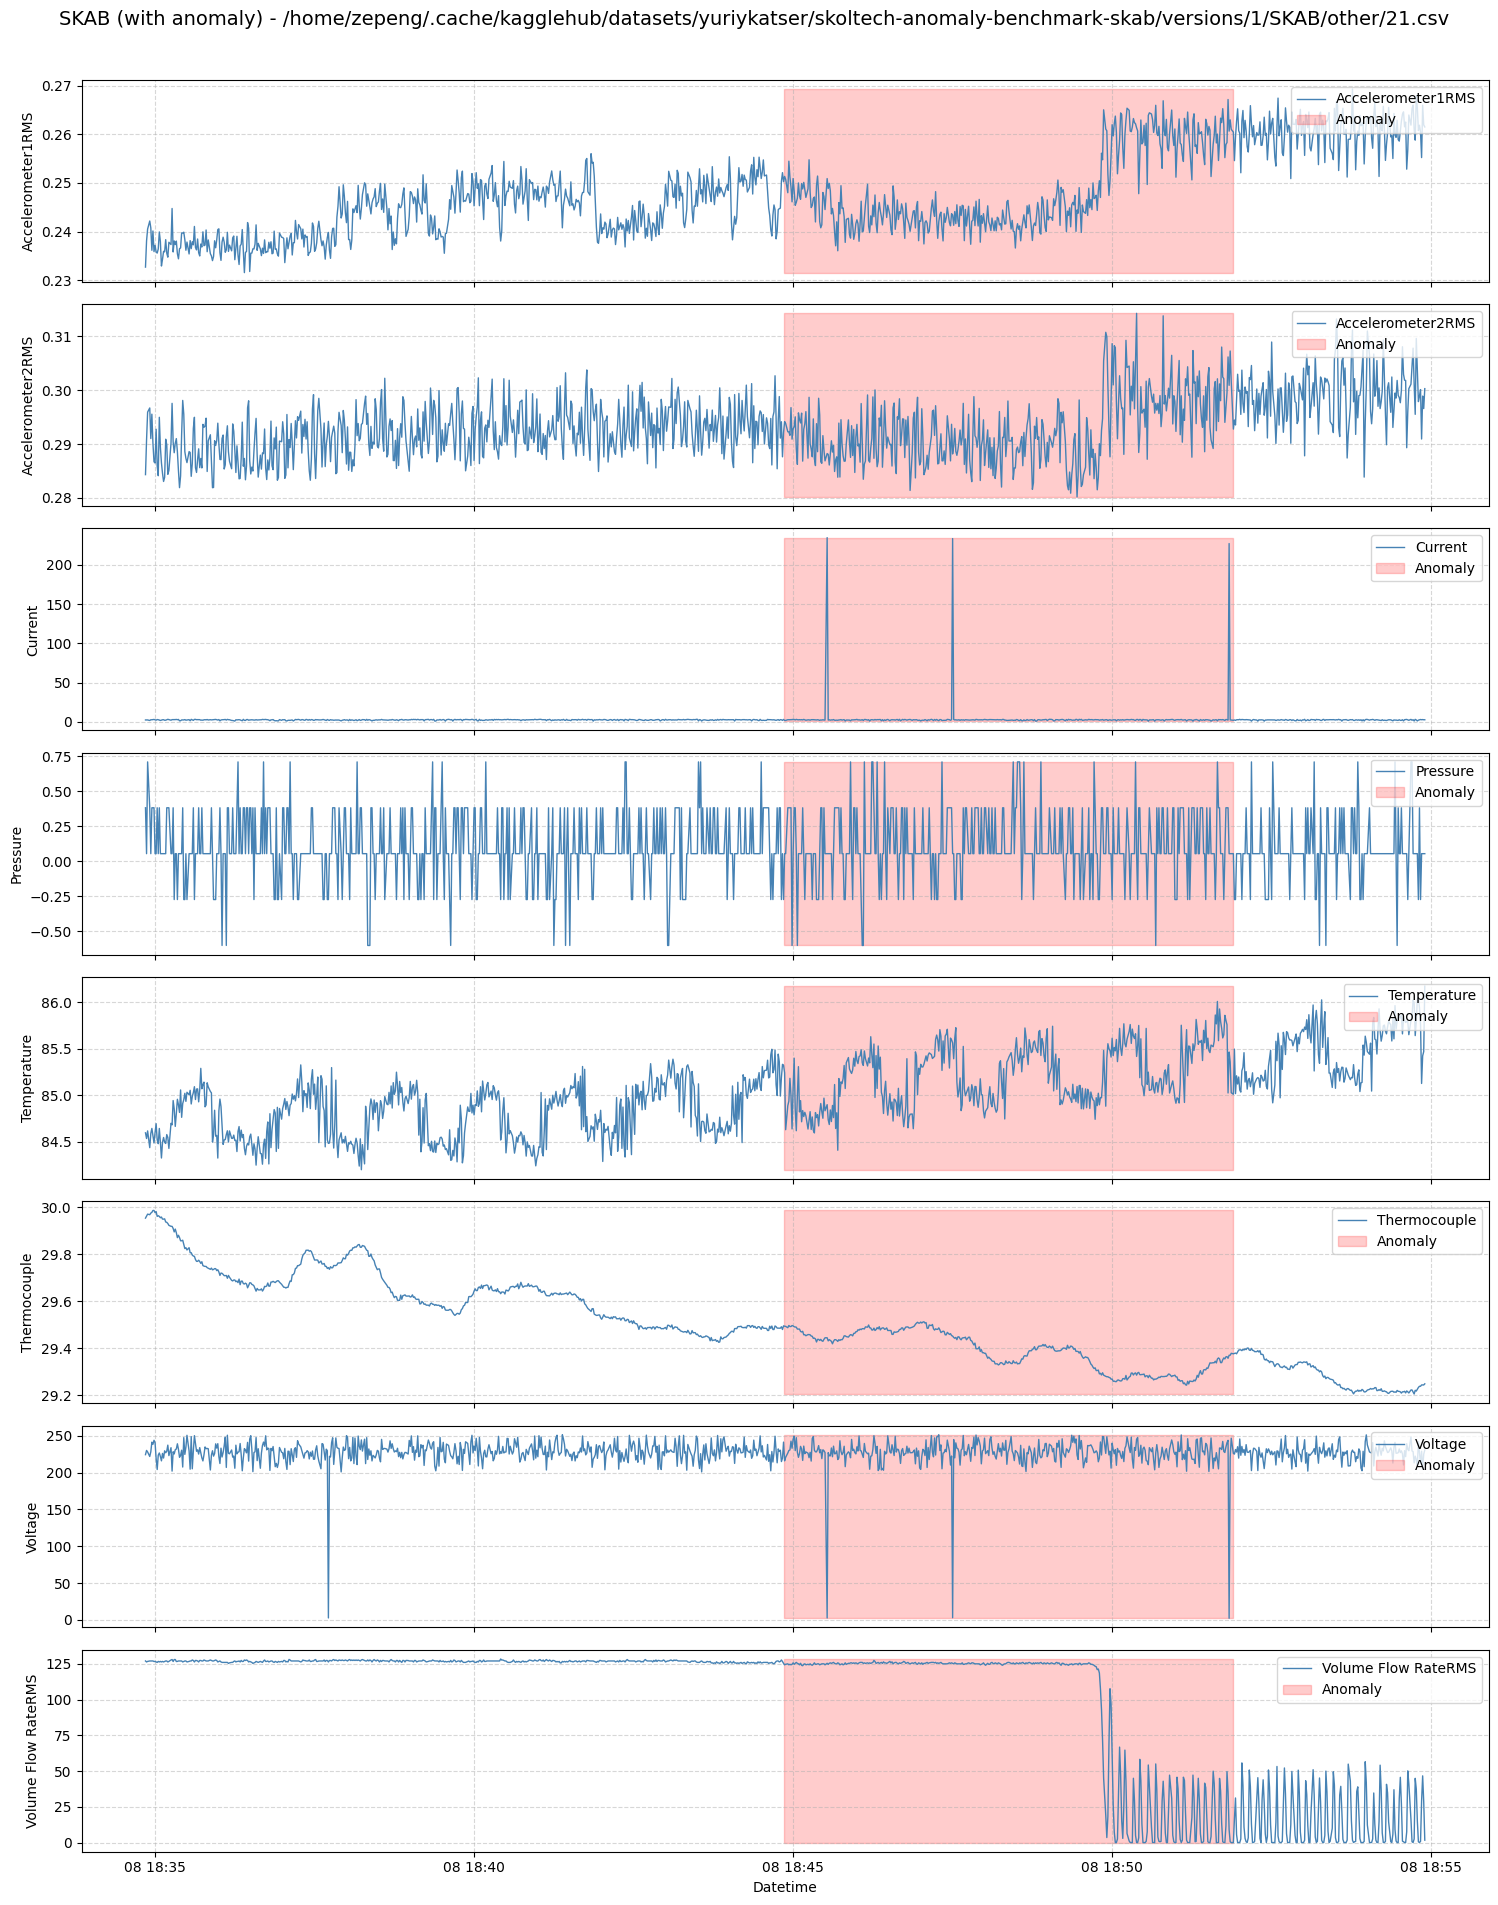

In [23]:
import matplotlib.pyplot as plt

def visualize_skab_data(data, title="SKAB Sensor Signals"):
    sensor_columns = [col for col in data.columns if col not in ['anomaly', 'changepoint']]

    fig, axes = plt.subplots(nrows=len(sensor_columns), ncols=1, 
                             figsize=(15, 2.5 * len(sensor_columns)), 
                             sharex=True, squeeze=False)

    for i, col in enumerate(sensor_columns):
        ax = axes[i, 0]
        ax.plot(data.index, data[col], label=col, color='steelblue', linewidth=1)

        if 'anomaly' in data.columns:
            ax.fill_between(data.index, data[col].min(), data[col].max(), 
                            where=data['anomaly'] == 1, color='red', alpha=0.2, label='Anomaly')
        
        ax.set_ylabel(col)
        ax.legend(loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.5)

    plt.xlabel('Datetime')
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

file_idx = 10
selected_file = anomaly_files[file_idx]

df = pd.read_csv(selected_file, sep=';', index_col='datetime', parse_dates=True)
if 'anomaly' in df.columns:
    df['anomaly'] = df['anomaly'].astype(int)

visualize_skab_data(df, title=f"SKAB (with anomaly) - {selected_file}")

## Test with 'timeeval'

### Format trasnformation

Canonical format:
```
timestamp,value,is_anomaly
0,12751.0,1
1,8767.0,0
2,7005.0,0
3,5257.0,0
4,4189.0,0
```

Idex file to form:

```
collection_name,dataset_name,train_path,test_path,dataset_type,datetime_index,split_at,train_type,train_is_normal,input_type,length,dimensions,contamination,num_anomalies,min_anomaly_length,median_anomaly_length,max_anomaly_length,mean,stddev,trend,stationarity,period_size
```


In [27]:
# process anomaly-free file to canonical format (train file)

# Note: in this dataset, sep=';'
anomaly_free_df = pd.read_csv(anomaly_free_files[0], sep=';', parse_dates=['datetime'])


# 2. Reset index if 'datetime' is the index
if anomaly_free_df.index.name == 'datetime':
    anomaly_free_df.reset_index(inplace=True)

anomaly_free_df.rename(columns={'datetime': 'timestamp'}, inplace=True)
cols = ['timestamp'] + [c for c in anomaly_free_df.columns if c != 'timestamp']
anomaly_free_df = anomaly_free_df[cols]
anomaly_free_df['is_anomaly'] = 0

print("Transformed to conanical format：")
display(anomaly_free_df.head())

Transformed to conanical format：


,timestamp,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,is_anomaly
0,2020-02-08 13:30:47,0.206030,0.277924,1.81019,0.382638,90.1740,26.7760,228.208,121.664,0
1,2020-02-08 13:30:48,0.204366,0.275727,2.66317,-0.273216,90.2836,26.7760,227.245,122.000,0
2,2020-02-08 13:30:49,0.206103,0.278526,2.63758,0.382638,89.8666,26.7821,237.872,122.000,0
3,2020-02-08 13:30:51,0.204775,0.276948,2.32851,0.382638,90.2192,26.7773,230.422,121.338,0
4,2020-02-08 13:30:52,0.206052,0.278141,2.53422,0.382638,90.1449,26.7773,219.454,121.664,0


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

selected_index = 10
src_path = anomaly_files[selected_index]

print(f"Processing: {src_path}")

df = pd.read_csv(src_path, sep=';', parse_dates=['datetime'])

if 'changepoint' in df.columns:
    df.drop(columns=['changepoint'], inplace=True)

df.rename(columns={'datetime': 'timestamp', 'anomaly': 'is_anomaly'}, inplace=True)
df['is_anomaly'] = df['is_anomaly'].astype(int)

feature_cols = [c for c in df.columns if c not in ['timestamp', 'is_anomaly']]
df = df[['timestamp'] + feature_cols + ['is_anomaly']]

src_path_obj = Path(src_path)
parent_folder_name = src_path_obj.parent.name 
file_stem = src_path_obj.stem
output_dir = Path("skabdata") / parent_folder_name
output_dir.mkdir(parents=True, exist_ok=True)
output_filename = f"{file_stem}.test.csv"
output_full_path = output_dir / output_filename
df.to_csv(output_full_path, index=False)
print(f"Saved dataset to: {output_full_path}")

train_filename = 'skab_anomaly_free.train.csv'
train_full_path = output_dir / train_filename

# 2. 保存文件
anomaly_free_df.to_csv(train_full_path, index=False)

# --- 新增：自动生成 Index 条目 ---

def calculate_anomaly_stats(y_true):
    """计算异常片段的统计信息"""
    # 找出连续的异常片段
    # 使用 diff 找出 0->1 和 1->0 的变化点
    changes = np.diff(np.r_[0, y_true, 0])
    starts = np.where(changes == 1)[0]
    ends = np.where(changes == -1)[0]
    
    lengths = ends - starts
    
    return {
        "num_anomalies": len(lengths),
        "min_anomaly_length": int(np.min(lengths)) if len(lengths) > 0 else 0,
        "median_anomaly_length": int(np.median(lengths)) if len(lengths) > 0 else 0,
        "max_anomaly_length": int(np.max(lengths)) if len(lengths) > 0 else 0,
    }

# 1. 基础信息
collection_name = "skab" 
dataset_type = "real" 
train_type = "semisupervised" 
input_type = "multivariate" if len(feature_cols) > 1 else "univariate"

# 2. 统计特征
length = len(df)
dimensions = len(feature_cols)
contamination = df['is_anomaly'].mean()
anomaly_stats = calculate_anomaly_stats(df['is_anomaly'].values)


data_values = df[feature_cols].values.flatten()
mean_val = float(np.mean(data_values))
std_val = float(np.std(data_values))

# 3. 构建元数据字典
meta_row = {
    "collection_name": collection_name,
    "dataset_name": f"{parent_folder_name}{file_stem}",
    "train_path": f"{parent_folder_name}/{train_filename}", # 空
    "test_path": f"{parent_folder_name}/{output_filename}", # 这里填写相对 DatasetManager 根目录的路径
    "dataset_type": dataset_type,
    "datetime_index": True,
    "split_at": np.nan,
    "train_type": train_type,
    "train_is_normal": True,
    "input_type": input_type,
    "length": length,
    "dimensions": dimensions,
    "contamination": contamination,
    "num_anomalies": anomaly_stats["num_anomalies"],
    "min_anomaly_length": anomaly_stats["min_anomaly_length"],
    "median_anomaly_length": anomaly_stats["median_anomaly_length"],
    "max_anomaly_length": anomaly_stats["max_anomaly_length"],
    "mean": mean_val,
    "stddev": std_val,
    "trend": "unknown",       # 较难自动计算，可填 unknown
    "stationarity": "unknown", # 较难自动计算，可填 unknown
    "period_size": np.nan      # 需周期检测算法，可填空
}

# 4. Create index CSV
index_file = "skabdata/datasets.csv" # 你的索引文件名
meta_df = pd.DataFrame([meta_row])
meta_df.to_csv(index_file, mode='w', header=True, index=False)

print("\n--- Generated Index Entry ---")
display(meta_df)
print(f"Appended metadata to {index_file}")


Processing: /home/zepeng/.cache/kagglehub/datasets/yuriykatser/skoltech-anomaly-benchmark-skab/versions/1/SKAB/other/21.csv
Saved dataset to: skabdata/other/21.test.csv

--- Generated Index Entry ---


,collection_name,dataset_name,train_path,test_path,dataset_type,datetime_index,split_at,train_type,train_is_normal,input_type,...,contamination,num_anomalies,min_anomaly_length,median_anomaly_length,max_anomaly_length,mean,stddev,trend,stationarity,period_size
0,skab,other21,other/skab_anomaly_free.train.csv,other/21.test.csv,real,True,NaN,semisupervised,False,multivariate,...,0.351446,1,401,401,401,55.553787,77.239392,unknown,unknown,NaN


Appended metadata to skabdata/datasets.csv


In [34]:
from pathlib import Path
from typing import Dict, Any

import numpy as np

from timeeval import TimeEval, DatasetManager, Algorithm, TrainingType, InputDimensionality
from timeeval.adapters import FunctionAdapter
from timeeval.algorithms import lstm_ad
from timeeval.params import FixedParameters

# Load dataset metadata
dm = DatasetManager(Path("skabdata"), create_if_missing=False)

# Select datasets and algorithms
datasets = dm.select()
datasets = datasets[-1:]
# Add algorithms to evaluate...
algorithms = [
   lstm_ad(params=FixedParameters({"epochs": 10}))
]
timeeval = TimeEval(dm, datasets, algorithms, force_training_type_match=False, force_dimensionality_match=False)

# execute evaluation
timeeval.run()
# retrieve results
print(timeeval.get_results())


Running PREPARE phase


KeyboardInterrupt: 